# BEM114 Homework 4 - Risk-Weighted Portfolios
**Names:** Andrew Zabelo, Daniel Wen, Kyle McCandless  
**Student IDs:** 2176083, 2159859, 2157818

## Setup

### Imports and Helper Functions

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [2]:
# Calculates returns and prints the returns mean, vol, and Sharpe ratio for a strategy
def analyze(returns, strat_name):
    strat_mean = returns.mean()
    strat_vol = returns.std()
    strat_sharpe = strat_mean / strat_vol
    print(f"{strat_name} monthly returns:")
    print(f"Mean = {strat_mean:.3f}%")
    print(f"Volatility = {strat_vol:0.3f}%")
    print(f"Sharpe Ratio = {strat_sharpe:0.3f}")

# Estimates the CAPM, FF3 and FF5+MOM models on df using the returns found in ret_col_name
def estimate_models(df, ret_col_name):
    # Estimate CAPM
    print('CAPM')
    print(sm.OLS(df[ret_col_name], sm.add_constant(df[['Mkt-RF']])).fit().summary())
    
    # Estimate FF3
    print('FF3')
    print(sm.OLS(df[ret_col_name], sm.add_constant(df[['Mkt-RF', 'SMB', 'HML']])).fit().summary())
    
    # Estimate FF5
    print('FF5 + MOM')
    print(sm.OLS(df[ret_col_name], sm.add_constant(df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']])).fit().summary())
    
# Plots the log cumulative returns for a strategy versus the CAPM-implied returns
def plot_log_cum_returns(df, return_col_name, title):
    dates = np.array(df.index.strftime('%Y%m'), dtype=int)
    dates = dates // 100 + (dates % 100) / 12
    
    strategy_cumulative = np.log((df[return_col_name] / 100 + 1.0).cumprod())
    market_cumulative = np.log(((df['Mkt-RF'] + df['RF']) / 100 + 1.0).cumprod())

    plt.figure()
    plt.plot(dates, strategy_cumulative, label=f'Volatility managed portfolio')
    plt.plot(dates, market_cumulative, label=f'Market portfolio')

    plt.title(f'{title} portfolio performance')
    plt.xlabel('Date')
    plt.ylabel('Log cumulative portfolio value')

    plt.legend()
    plt.show()

### Load monthly and daily FF5 and MOM returns data

In [3]:
mff5 = pd.read_csv('data/FF5_monthly.csv')
mff5['date'] = pd.to_datetime(mff5['date'], format='%Y%m')

dff5 = pd.read_csv('data/FF5_daily.csv')
dff5['date'] = pd.to_datetime(dff5['date'], format='%Y%m%d')

mmom = pd.read_csv('data/MOM_monthly.csv')
mmom['date'] = pd.to_datetime(mmom['date'], format='%Y%m')

dmom = pd.read_csv('data/MOM_daily.csv')
dmom['date'] = pd.to_datetime(dmom['date'], format='%Y%m%d')

## Problem 1

### Part A

In [4]:
# Merge monthly FF5 and MOM data
mdf = pd.merge(mff5, mmom, on='date', how='outer')
assert(len(mdf) == len(mmom))

# Set dates to months with no days
mdf['date'] = mdf['date'].dt.to_period('M')
mdf = mdf.sort_values(by='date')
mdf.set_index('date', inplace=True)
mdf

,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM
date,,,,,,,
1927-01,NaN,NaN,NaN,NaN,NaN,NaN,0.36
1927-02,NaN,NaN,NaN,NaN,NaN,NaN,-2.14
1927-03,NaN,NaN,NaN,NaN,NaN,NaN,3.61
1927-04,NaN,NaN,NaN,NaN,NaN,NaN,4.30
1927-05,NaN,NaN,NaN,NaN,NaN,NaN,3.00
...,...,...,...,...,...,...,...
2023-11,8.84,-0.12,1.64,-3.91,-1.00,0.44,2.75
2023-12,4.87,7.32,4.93,-3.07,1.32,0.43,-5.51
2024-01,0.71,-5.74,-2.38,0.69,-0.96,0.47,5.19


In [22]:
# Merge daily FF5 and MOM data
ddf = pd.merge(dff5, dmom, on='date', how='outer')
assert(len(ddf) == len(dmom))

ddf = ddf.sort_values(by='date')
ddf

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM
15290,1926-11-03,NaN,NaN,NaN,NaN,NaN,NaN,0.56
15291,1926-11-04,NaN,NaN,NaN,NaN,NaN,NaN,-0.50
15292,1926-11-05,NaN,NaN,NaN,NaN,NaN,NaN,1.17
15293,1926-11-06,NaN,NaN,NaN,NaN,NaN,NaN,-0.03
15294,1926-11-08,NaN,NaN,NaN,NaN,NaN,NaN,-0.01
...,...,...,...,...,...,...,...,...
15285,2024-03-22,-0.23,-0.98,-0.53,0.29,-0.37,0.021,0.43
15286,2024-03-25,-0.26,-0.10,0.88,-0.22,-0.17,0.021,-0.34
15287,2024-03-26,-0.26,0.10,-0.13,-0.50,0.23,0.021,0.09
15288,2024-03-27,0.88,1.29,0.91,-0.14,0.58,0.021,-1.34


### Part B

In [23]:
FACTORS = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']
FACTORS_var = [name + '_var' for name in FACTORS]
FACTORS_lag = [name + '_lag' for name in FACTORS]

# Compute 22-day rolling variance
ddf[FACTORS_var] = ddf[FACTORS].rolling(window=22, min_periods=22).var()
ddf

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM,Mkt-RF_var,SMB_var,HML_var,RMW_var,CMA_var,MOM_var
15290,1926-11-03,NaN,NaN,NaN,NaN,NaN,NaN,0.56,NaN,NaN,NaN,NaN,NaN,NaN
15291,1926-11-04,NaN,NaN,NaN,NaN,NaN,NaN,-0.50,NaN,NaN,NaN,NaN,NaN,NaN
15292,1926-11-05,NaN,NaN,NaN,NaN,NaN,NaN,1.17,NaN,NaN,NaN,NaN,NaN,NaN
15293,1926-11-06,NaN,NaN,NaN,NaN,NaN,NaN,-0.03,NaN,NaN,NaN,NaN,NaN,NaN
15294,1926-11-08,NaN,NaN,NaN,NaN,NaN,NaN,-0.01,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15285,2024-03-22,-0.23,-0.98,-0.53,0.29,-0.37,0.021,0.43,0.505910,0.708938,0.458988,0.309487,0.250368,0.683857
15286,2024-03-25,-0.26,-0.10,0.88,-0.22,-0.17,0.021,-0.34,0.349962,0.607054,0.395853,0.307150,0.185330,0.517176
15287,2024-03-26,-0.26,0.10,-0.13,-0.50,0.23,0.021,0.09,0.355926,0.601206,0.397961,0.319346,0.186243,0.516868
15288,2024-03-27,0.88,1.29,0.91,-0.14,0.58,0.021,-1.34,0.376593,0.637681,0.421055,0.293502,0.199281,0.558861


### Part C

In [24]:
# Collapse data to the end of month level
ddf.set_index('date', inplace=True)
ddf = ddf.resample('M').last()
ddf.index = ddf.index.to_period('M')

# Drop daily returns and pull in monthly returns instead
ddf = ddf.drop(FACTORS+['RF'], axis=1)
df = pd.merge(ddf, mdf, left_index=True, right_index=True, how='inner')
assert len(df) == len(ddf)-2 # 2 rows lost because monthly data starts 2 months later
df

,Mkt-RF_var,SMB_var,HML_var,RMW_var,CMA_var,MOM_var,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM
date,,,,,,,,,,,,,
1927-01,NaN,NaN,NaN,NaN,NaN,0.153899,NaN,NaN,NaN,NaN,NaN,NaN,0.36
1927-02,NaN,NaN,NaN,NaN,NaN,0.126329,NaN,NaN,NaN,NaN,NaN,NaN,-2.14
1927-03,NaN,NaN,NaN,NaN,NaN,0.205204,NaN,NaN,NaN,NaN,NaN,NaN,3.61
1927-04,NaN,NaN,NaN,NaN,NaN,0.211921,NaN,NaN,NaN,NaN,NaN,NaN,4.30
1927-05,NaN,NaN,NaN,NaN,NaN,0.239990,NaN,NaN,NaN,NaN,NaN,NaN,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11,0.547768,1.151056,0.410597,0.353418,0.090708,1.064724,8.84,-0.12,1.64,-3.91,-1.00,0.44,2.75
2023-12,0.406426,0.973010,0.476797,0.187247,0.102177,0.804803,4.87,7.32,4.93,-3.07,1.32,0.43,-5.51
2024-01,0.537473,0.613752,0.340327,0.271399,0.087964,0.581611,0.71,-5.74,-2.38,0.69,-0.96,0.47,5.19


In [25]:
# Lag the factor return variance
df[FACTORS_lag] = df[FACTORS_var].shift(1)

for f in FACTORS:
    # Drop NaNs and complete regression of variance on last month's variance
    temp = df.dropna(subset=[f+'_lag', f+'_var'])
    print(f'\n\n{f}:')
    print(sm.OLS(temp[f'{f}_var'], sm.add_constant(temp[f'{f}_lag'])).fit().summary())

728


Mkt-RF:
                            OLS Regression Results                            
Dep. Variable:             Mkt-RF_var   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     189.9
Date:                Tue, 07 May 2024   Prob (F-statistic):           1.51e-38
Time:                        23:19:32   Log-Likelihood:                -1519.8
No. Observations:                 728   AIC:                             3044.
Df Residuals:                     726   BIC:                             3053.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5672      0.080      

**For all 5 Fama French factors and momentum, the coefficient on lagged variance is positive and significant at the 1% level**, indicating that the variance is time-persistent. Variance in the last 22 days of a previous month positively correlates with variance in the last 22 days of the next month.

### Part D

In [9]:
for f in FACTORS:
    # Drop NaNs and complete regression of returns on last month's variance
    temp = df.dropna(subset=[f, f+'_lag'])
    print(f'\n\n{f}:')
    print(sm.OLS(temp[f], sm.add_constant(temp[f'{f}_lag'])).fit().summary())



Mkt-RF:
                            OLS Regression Results                            
Dep. Variable:                 Mkt-RF   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.007564
Date:                Tue, 07 May 2024   Prob (F-statistic):              0.931
Time:                        23:15:48   Log-Likelihood:                -2126.6
No. Observations:                 728   AIC:                             4257.
Df Residuals:                     726   BIC:                             4266.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5858      0.185      3.17

**The RMW, CMA, and MOM factors have coefficients that are significant at the 1% level, but Mkt-RF, SMB, and HML all fail to be significant,** indicating that variance doesn't strongly predict returns for Mkt-RF, SMB, and HML, but it does for RMW, CMA, and MOM. The RMW and CMA coefficients were positive, while the MOM coefficient was negative, so variance positively predicts future returns for RMW and CMA, but negatively predicts future returns for MOM.

### Part E

In [10]:
'''
Calculate volatility managed portfolio weights
'''

WEIGHTS = ['w_Mkt-RF', 'w_SMB', 'w_HML', 'w_RMW', 'w_CMA', 'w_MOM']

p = df.drop(FACTORS_lag+['RF'], axis=1)
for f in FACTORS:
    # Create each factor's weight
    p['w_'+f] = p[f+'_var'].mean() / p[f+'_var']

p = p.drop(FACTORS_var, axis=1)
p

,Mkt-RF,SMB,HML,RMW,CMA,MOM,w_Mkt-RF,w_SMB,w_HML,w_RMW,w_CMA,w_MOM
date,,,,,,,,,,,,
1927-01,NaN,NaN,NaN,NaN,NaN,0.36,NaN,NaN,NaN,NaN,NaN,3.743867
1927-02,NaN,NaN,NaN,NaN,NaN,-2.14,NaN,NaN,NaN,NaN,NaN,4.560925
1927-03,NaN,NaN,NaN,NaN,NaN,3.61,NaN,NaN,NaN,NaN,NaN,2.807830
1927-04,NaN,NaN,NaN,NaN,NaN,4.30,NaN,NaN,NaN,NaN,NaN,2.718824
1927-05,NaN,NaN,NaN,NaN,NaN,3.00,NaN,NaN,NaN,NaN,NaN,2.400833
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11,8.84,-0.12,1.64,-3.91,-1.00,2.75,1.898766,0.254648,0.812819,0.443854,1.548140,0.541152
2023-12,4.87,7.32,4.93,-3.07,1.32,-5.51,2.559097,0.301245,0.699964,0.837750,1.374365,0.715923
2024-01,0.71,-5.74,-2.38,0.69,-0.96,5.19,1.935136,0.477578,0.980648,0.577990,1.596432,0.990657


In [11]:
'''
Calculate volatility managed portfolio returns
'''

# Shift all weights and drop the resulting NaNs
p[WEIGHTS] = p[WEIGHTS].shift(1)
p = p.dropna(subset=WEIGHTS+FACTORS)

# Calculate returns -- leave out RF returns according to the hint
for name in FACTORS:
    p[name+"_ret"] = p[name]*p['w_'+name] #+ p['RF']*(1 - p['w_'+name])

p = p.drop(WEIGHTS, axis=1)
p

,Mkt-RF,SMB,HML,RMW,CMA,MOM,Mkt-RF_ret,SMB_ret,HML_ret,RMW_ret,CMA_ret,MOM_ret
date,,,,,,,,,,,,
1963-08,5.07,-0.80,1.80,0.36,-0.35,1.01,23.570054,-11.199395,15.857541,2.548420,-1.552810,7.552701
1963-09,-1.57,-0.52,0.13,-0.71,0.29,0.19,-18.780303,-4.529176,1.097268,-8.377461,1.760738,2.294941
1963-10,2.53,-1.39,-0.10,2.80,-2.01,3.12,17.062409,-7.749245,-0.952061,15.282567,-10.050810,24.732131
1963-11,-0.85,-0.88,1.75,-0.51,2.24,-0.74,-5.158898,-3.329914,5.015116,-1.296665,3.669249,-4.516425
1963-12,1.83,-2.10,-0.02,0.03,-0.07,1.75,1.274020,-2.963631,-0.083466,0.050660,-0.120060,1.575691
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11,8.84,-0.12,1.64,-3.91,-1.00,2.75,10.645030,-0.085194,1.504271,-1.432600,-0.962743,2.821396
2023-12,4.87,7.32,4.93,-3.07,1.32,-5.51,9.246989,1.864025,4.007197,-1.362632,2.043544,-2.981746
2024-01,0.71,-5.74,-2.38,0.69,-0.96,5.19,1.816959,-1.729148,-1.665915,0.578048,-1.319391,3.715642


In [12]:
for name in FACTORS:
    analyze(p[name+'_ret'], f'{name} volatility-managed portfolio')
    print()

Mkt-RF volatility-managed portfolio monthly returns:
Mean = 1.456%
Volatility = 11.135%
Sharpe Ratio = 0.131

SMB volatility-managed portfolio monthly returns:
Mean = 0.344%
Volatility = 7.711%
Sharpe Ratio = 0.045

HML volatility-managed portfolio monthly returns:
Mean = 0.951%
Volatility = 9.549%
Sharpe Ratio = 0.100

RMW volatility-managed portfolio monthly returns:
Mean = 0.856%
Volatility = 5.205%
Sharpe Ratio = 0.164

CMA volatility-managed portfolio monthly returns:
Mean = 0.438%
Volatility = 4.081%
Sharpe Ratio = 0.107

MOM volatility-managed portfolio monthly returns:
Mean = 3.991%
Volatility = 13.729%
Sharpe Ratio = 0.291



### Part F

In [13]:
for name in FACTORS:
    print('----------------------------------------------------------------------------')
    print(name)
    print('----------------------------------------------------------------------------')
    estimate_models(p, name+'_ret')

----------------------------------------------------------------------------
Mkt-RF
----------------------------------------------------------------------------
CAPM
                            OLS Regression Results                            
Dep. Variable:             Mkt-RF_ret   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     593.1
Date:                Tue, 07 May 2024   Prob (F-statistic):           3.22e-96
Time:                        23:15:48   Log-Likelihood:                -2569.7
No. Observations:                 728   AIC:                             5143.
Df Residuals:                     726   BIC:                             5153.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t 

**The RMW and MOM strategies produce positive and significant alpha at the 1% level under all three models. The HML strategy produces significant alpha at the 1% level under the CAPM and FF5+MOM, but not under FF3. The CMA strategy produces significant alpha at the 1% level under CAPM and the 5% level under FF3. Finally, the Mkt-RF and SMB strategies fail to produce significant alpha.**

As we found in Part C, the variance of each of these factors positively predicts future variance. Our strategy gives low weights to currently high-variance factors, and higher weights when the factors are lower variance. As we discussed in class, this volatility managed portfolio is taking advantage of the discovery that high volatility assets tend to underperform. Because the current variance of these factors predicts the future variance, underweighting them in times of high variance at one month backs the strategy out of the next month, where it is statistically likely to see underperforming returns for that risk level.

## Problem 2

### Part A

In [14]:
# Create aggregate portfolio df
agg = df.drop(FACTORS_lag, axis=1)
agg = agg.dropna(subset=FACTORS+FACTORS_var)

# Calculate reciprocal of variance
for f in FACTORS:
    agg[f+'_var'] = 1 / agg[f+'_var']

# Calculate sum of variance reciprocals
agg['var_sum'] = agg['Mkt-RF_var'] + agg['SMB_var'] + agg['HML_var'] + agg['RMW_var'] + agg['CMA_var'] + agg['MOM_var']
agg

,Mkt-RF_var,SMB_var,HML_var,RMW_var,CMA_var,MOM_var,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM,var_sum
date,,,,,,,,,,,,,,
1963-07,4.469762,47.760330,26.396983,45.127324,31.593416,12.978512,-0.39,-0.41,-0.97,0.68,-1.18,0.27,0.90,168.326327
1963-08,11.500977,29.715197,25.290679,75.218573,43.235757,20.963409,5.07,-0.80,1.80,0.36,-0.35,0.25,1.01,205.924592
1963-09,6.484129,19.019860,28.526971,34.794397,35.608309,13.757862,-1.57,-0.52,0.13,-0.71,0.29,0.27,0.19,138.191526
1963-10,5.835389,12.909608,8.586850,16.207967,11.664752,10.592710,2.53,-1.39,-0.10,2.80,-2.01,0.29,3.12,65.797276
1963-11,0.669356,4.814682,12.504567,10.765115,12.213660,1.562705,-0.85,-0.88,1.75,-0.51,2.24,0.27,-0.74,42.530085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11,1.825590,0.868767,2.435481,2.829509,11.024438,0.939211,8.84,-0.12,1.64,-3.91,-1.00,0.44,2.75,19.922995
2023-12,2.460473,1.027739,2.097331,5.340547,9.786974,1.242540,4.87,7.32,4.93,-3.07,1.32,0.43,-5.51,21.955604
2024-01,1.860559,1.629324,2.938354,3.684610,11.368334,1.719361,0.71,-5.74,-2.38,0.69,-0.96,0.47,5.19,23.200542


In [15]:
# Create each factor's weight
for f in FACTORS:
    agg['w_'+f] = agg[f+'_var'] / agg['var_sum']
agg = agg.drop(FACTORS_var, axis=1)

# Shift all weights and drop the resulting NaNs
agg[WEIGHTS] = agg[WEIGHTS].shift(1)
agg = agg.dropna(subset=WEIGHTS+FACTORS)
agg

,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM,var_sum,w_Mkt-RF,w_SMB,w_HML,w_RMW,w_CMA,w_MOM
date,,,,,,,,,,,,,,
1963-08,5.07,-0.80,1.80,0.36,-0.35,0.25,1.01,205.924592,0.026554,0.283737,0.156820,0.268094,0.187691,0.077103
1963-09,-1.57,-0.52,0.13,-0.71,0.29,0.27,0.19,138.191526,0.055850,0.144301,0.122815,0.365272,0.209959,0.101801
1963-10,2.53,-1.39,-0.10,2.80,-2.01,0.29,3.12,65.797276,0.046921,0.137634,0.206431,0.251784,0.257674,0.099556
1963-11,-0.85,-0.88,1.75,-0.51,2.24,0.27,-0.74,42.530085,0.088687,0.196203,0.130505,0.246332,0.177283,0.160990
1963-12,1.83,-2.10,-0.02,0.03,-0.07,0.29,1.75,79.656043,0.015738,0.113206,0.294017,0.253118,0.287177,0.036744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11,8.84,-0.12,1.64,-3.91,-1.00,0.44,2.75,19.922995,0.066922,0.140002,0.158861,0.135009,0.396280,0.102925
2023-12,4.87,7.32,4.93,-3.07,1.32,0.43,-5.51,21.955604,0.091632,0.043606,0.122245,0.142022,0.553352,0.047142
2024-01,0.71,-5.74,-2.38,0.69,-0.96,0.47,5.19,23.200542,0.112066,0.046810,0.095526,0.243243,0.445762,0.056593


In [16]:
# Calculate returns -- leave out RF returns according to the hint
agg['RET'] = agg['Mkt-RF']*agg['w_Mkt-RF'] + agg['SMB']*agg['w_SMB'] + agg['HML']*agg['w_HML'] + agg['RMW']*agg['w_RMW'] + agg['CMA']*agg['w_CMA'] + agg['MOM']*agg['w_MOM']
agg = agg.drop(WEIGHTS+['var_sum'], axis=1)
agg

,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM,RET
date,,,,,,,,
1963-08,5.07,-0.80,1.80,0.36,-0.35,0.25,1.01,0.298613
1963-09,-1.57,-0.52,0.13,-0.71,0.29,0.27,0.19,-0.325869
1963-10,2.53,-1.39,-0.10,2.80,-2.01,0.29,3.12,0.404444
1963-11,-0.85,-0.88,1.75,-0.51,2.24,0.27,-0.74,0.132693
1963-12,1.83,-2.10,-0.02,0.03,-0.07,0.29,1.75,-0.163020
...,...,...,...,...,...,...,...,...
2023-11,8.84,-0.12,1.64,-3.91,-1.00,0.44,2.75,0.194203
2023-12,4.87,7.32,4.93,-3.07,1.32,0.43,-5.51,1.402778
2024-01,0.71,-5.74,-2.38,0.69,-0.96,0.47,5.19,-0.382848


In [17]:
analyze(agg['RET'], f'Aggregate volatility-managed factor portfolio')

Aggregate volatility-managed factor portfolio monthly returns:
Mean = 0.324%
Volatility = 1.042%
Sharpe Ratio = 0.311


### Part B

In [18]:
estimate_models(agg, 'RET')

CAPM
                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.481
Date:                Tue, 07 May 2024   Prob (F-statistic):             0.0625
Time:                        23:15:48   Log-Likelihood:                -1060.9
No. Observations:                 728   AIC:                             2126.
Df Residuals:                     726   BIC:                             2135.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3333      0.039      8.573    

**The aggregate volatility managed portfolio has positive and significant alphas at the 1% level for all models.** The monthly alphas range from 0.075 under FF5+MOM to 0.331 under CAPM. In general, each composite volatility managed portfolio has higher alphas than the aggregate portfolio. 

The Sharpe ratios of each of the compostive factor portfolios (Mkt-RF = 0.130, SMB = 0.045, HML = 0.099, RMW = 0.164, CMA = 0.107, MOM = 0.291) are all lower than the aggregate portfolio's Sharpe ratio of 0.309, though all of the returns are higher.

### Part C

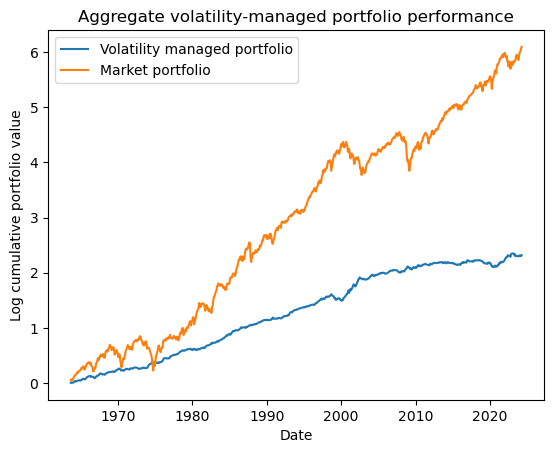

In [19]:
plot_log_cum_returns(agg, 'RET', 'Aggregate volatility-managed')

In [20]:
# Performance of aggregate volatility managed portfolio before 2000
agg_before_2000 = agg[agg.index < pd.Period(year=2000, month=1, freq='M')]

analyze(agg_before_2000['RET'], f'Aggregate volatility-managed factor portfolio')
estimate_models(agg_before_2000, 'RET')

Aggregate volatility-managed factor portfolio monthly returns:
Mean = 0.345%
Volatility = 0.842%
Sharpe Ratio = 0.411
CAPM
                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.748
Date:                Tue, 07 May 2024   Prob (F-statistic):             0.0535
Time:                        23:15:48   Log-Likelihood:                -542.33
No. Observations:                 437   AIC:                             1089.
Df Residuals:                     435   BIC:                             1097.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

In [21]:
# Performance of aggregate volatility managed portfolio since 2000
agg_since_2000 = agg[agg.index >= pd.Period(year=2000, month=1, freq='M')]

analyze(agg_since_2000['RET'], f'Aggregate volatility-managed factor portfolio')
estimate_models(agg_since_2000, 'RET')

Aggregate volatility-managed factor portfolio monthly returns:
Mean = 0.292%
Volatility = 1.287%
Sharpe Ratio = 0.227
CAPM
                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7132
Date:                Tue, 07 May 2024   Prob (F-statistic):              0.399
Time:                        23:15:48   Log-Likelihood:                -485.49
No. Observations:                 291   AIC:                             975.0
Df Residuals:                     289   BIC:                             982.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

The aggregate volatility managed portfolio produces alpha at the 1% significance level, before and after the turn of the century. However, after 2000, the Sharpe ratio roughly halves from 0.411 to 0.223, with monthly returns decreasing from 0.345% to 0.287%.